In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import statsmodels.api as sm

In [6]:
warnings.filterwarnings("ignore")

In [7]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()
    
def plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half):
    plt.figure(figsize=(10, 6))
    plt.scatter(column.index, column, label='Original Values')
    plt.plot(column.index, linear_a * column.index + linear_b, color='red', label='Linear Regression')
    plt.plot(column.index, linear_a_half * column.index + linear_b_half, color='green', label='Recent Linear Regression')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Original Values vs. Linear Regression vs. Recent Linear Regression')
    plt.grid(True)
    plt.show()

In [8]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [9]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column

def extract_valid_values(column):
    valid_values = []
    valid_indexes = []
    for index, value in enumerate(column):
        if not pd.isnull(value) and not np.isnan(value):
            valid_values.append(value)
            valid_indexes.append(index)
    extracted_column = pd.Series(
        valid_values,
        index=valid_indexes
    )
    return extracted_column

def linear_regression_first_four_filler(column):
    size = len(column) - 1
    processed_column = extract_valid_values(column)
    mean_valid_values_quarter = processed_column.mean()/4
    mean_valid_values_quarter_upper = processed_column.mean() + mean_valid_values_quarter
    
    model = sm.OLS(processed_column, sm.add_constant(processed_column.index))
    result = model.fit()
    linear_a = result.params[1]
    linear_b = result.params['const']
    half_column = processed_column[:(len(processed_column) // 2)]
    model2 = sm.OLS(half_column, sm.add_constant(half_column.index))
    result2 = model2.fit()
    linear_a_half = result2.params[1]
    linear_b_half = result2.params['const']
    
    for i in range(0,4):
        if pd.isnull(column.at[i]) or np.isnan(column.at[i]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[i] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[i] = mean_valid_values_quarter_upper
            else:
                column.at[i] = projected
        x = size - 4 + i
        if pd.isnull(column.at[x]) or np.isnan(column.at[x]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[x] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[x] = mean_valid_values_quarter_upper
            else:
                column.at[x] = projected
    plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half)
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [10]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = linear_regression_first_four_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

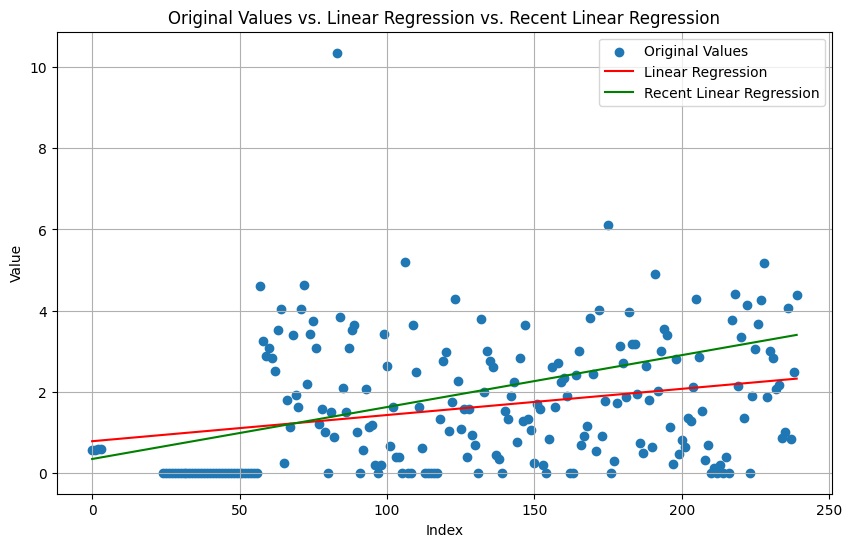

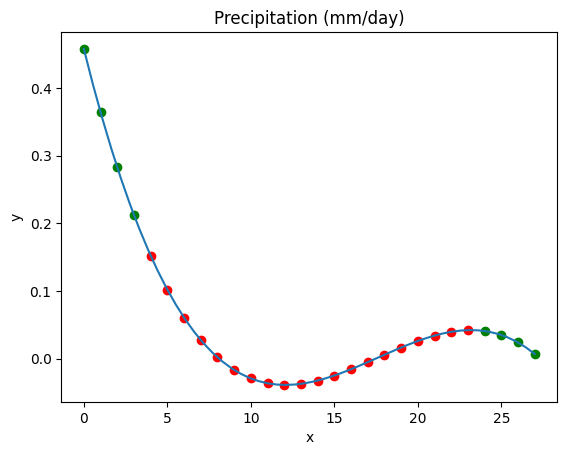

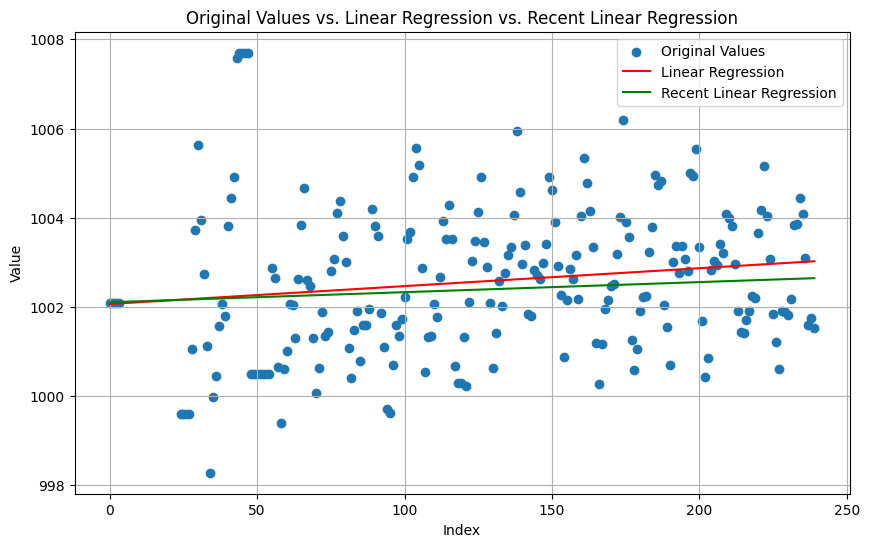

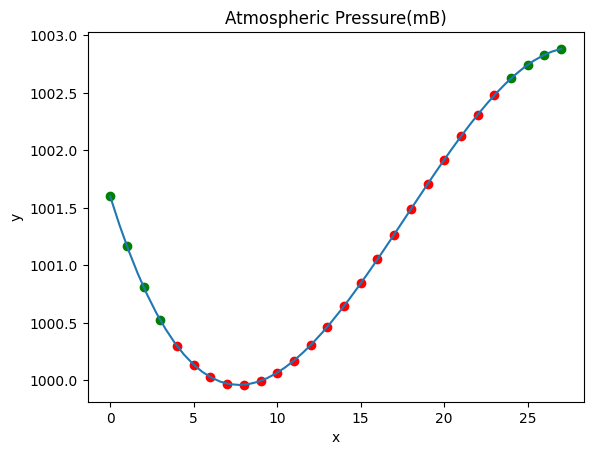

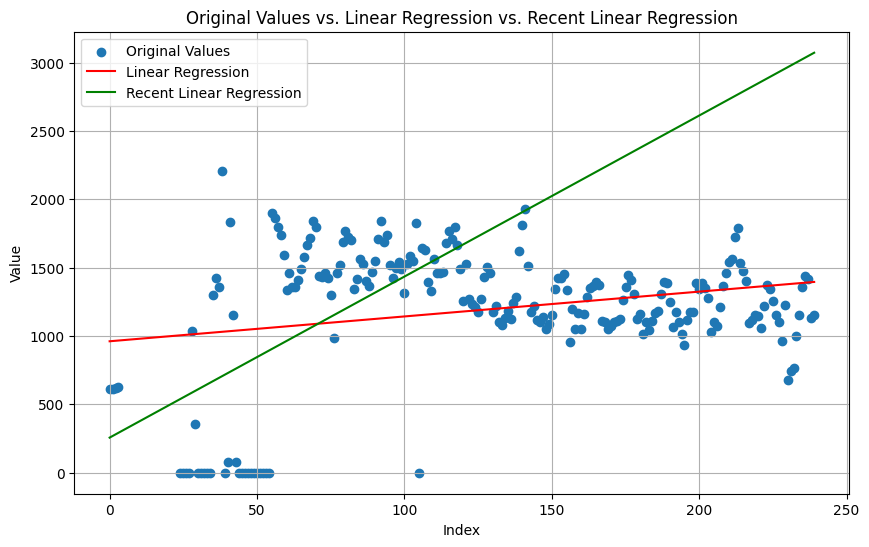

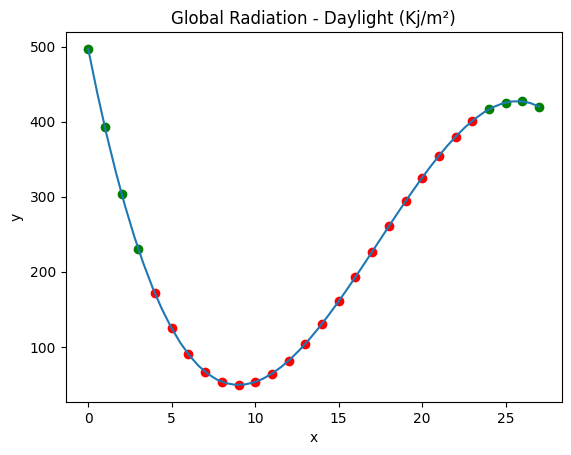

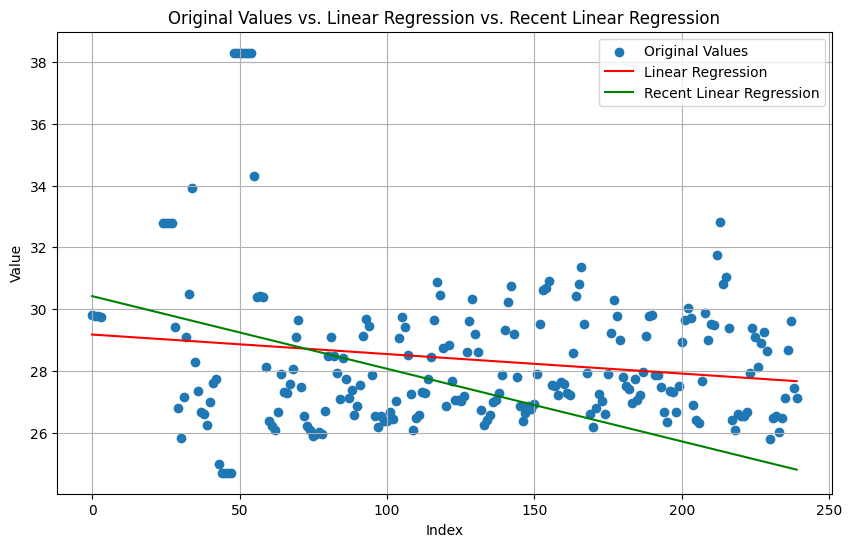

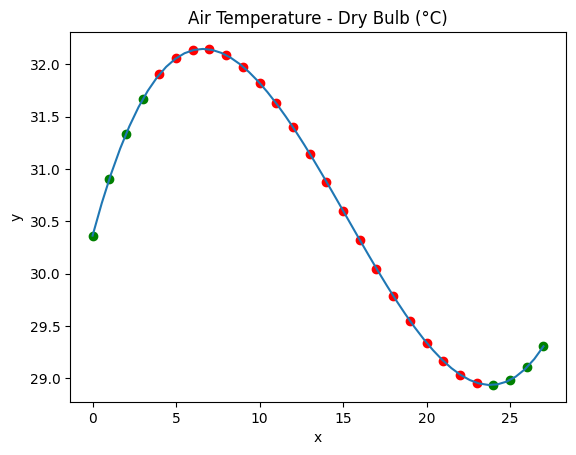

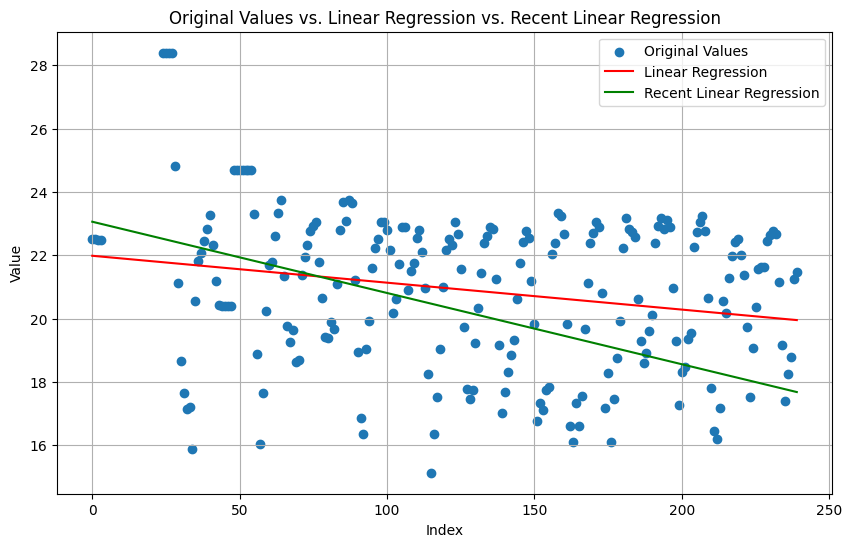

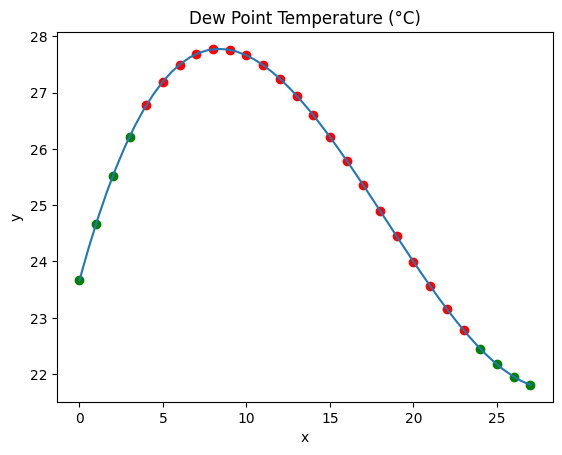

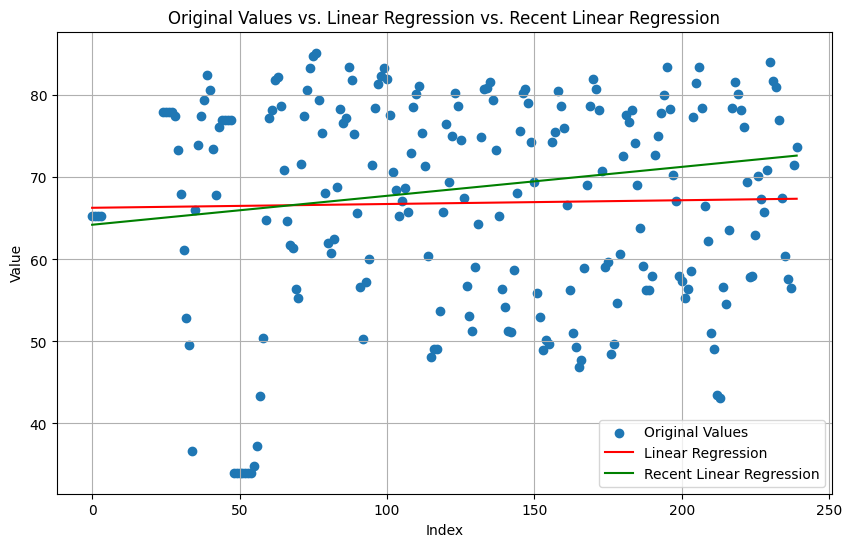

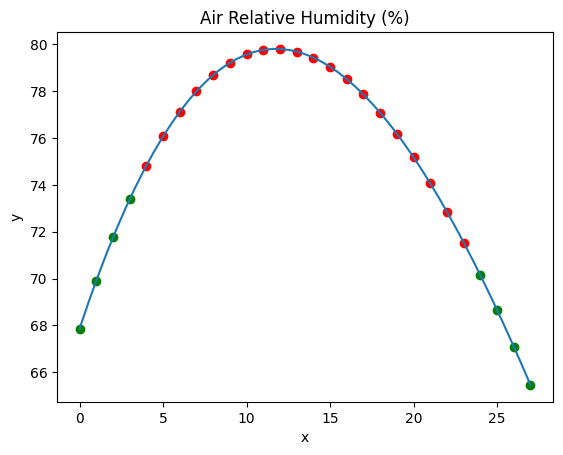

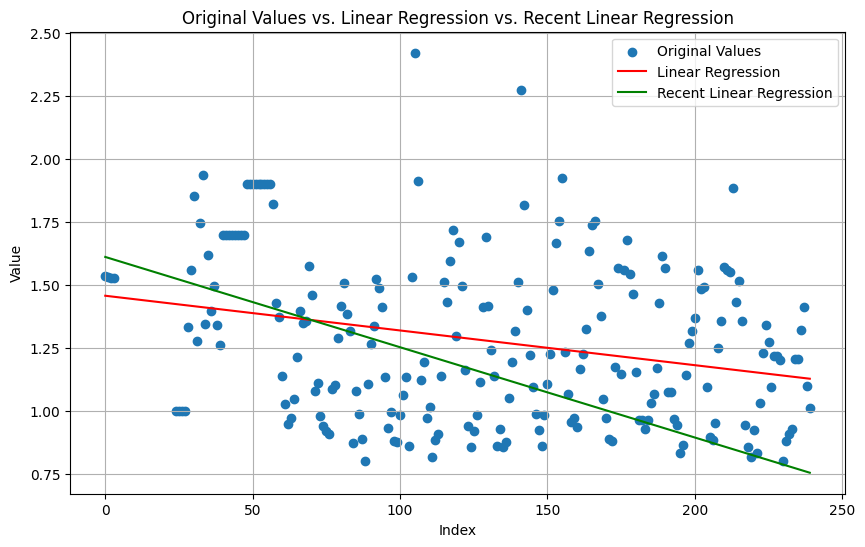

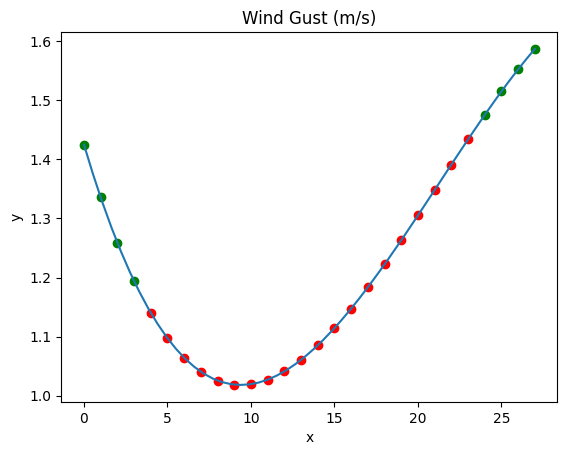

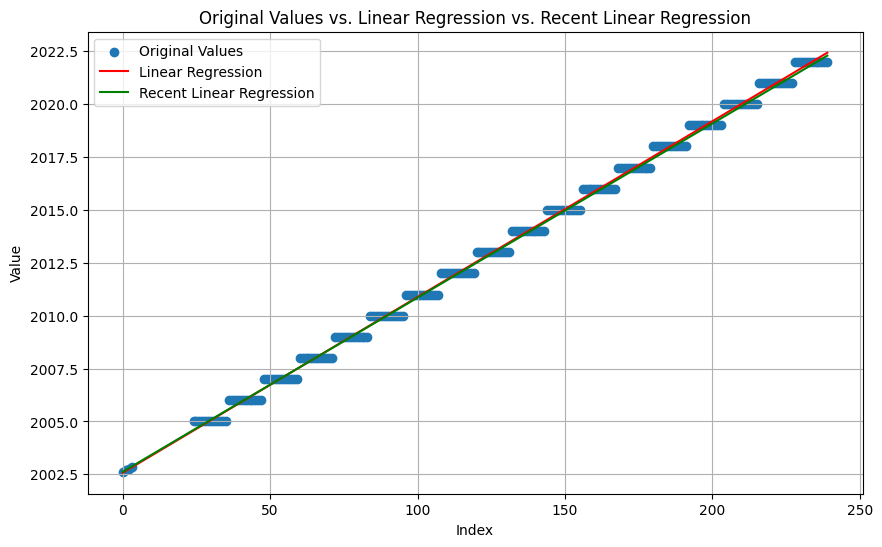

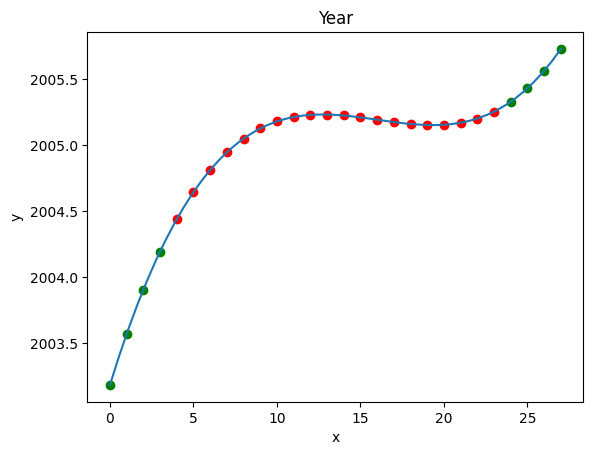

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2003,0.457716,1001.592366,495.550567,30.379457,23.678939,67.830983,1.424916
1,2003,0.364766,1001.178073,394.010505,30.880008,24.658615,69.954512,1.335772
2,2003,0.283719,1000.822517,306.004943,31.311182,25.500554,71.771832,1.259717
3,2003,0.211599,1000.511014,228.150257,31.690324,26.239189,73.359495,1.193479
4,2003,0.152478,1000.300034,171.085275,31.902619,26.771593,74.824184,1.140511
...,...,...,...,...,...,...,...,...
235,2022,2.257957,1002.683041,1216.674128,27.978729,20.392060,67.226146,1.172787
236,2022,2.315055,1002.629158,1210.765052,27.999913,20.495783,67.491652,1.170616
237,2022,2.261871,1002.606549,1201.422053,27.966410,20.578566,67.880525,1.164112
238,2022,2.326006,1002.640213,1191.931877,27.894542,20.648126,68.348896,1.153560


In [11]:
df = read_csv_replace_missing_by_polynomial('piaui_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df.drop(columns='Year', inplace=True)
df.head(len(df))

In [12]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
df_year

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2003,1.662891,1000.394769,174.703219,31.667291,26.657973,75.511112,1.137362
2004,0.164626,1001.383287,242.605103,30.019420,25.082951,76.766402,1.216410
2005,0.807185,1002.804857,471.414128,29.772312,21.817835,62.893680,1.622106
2006,8.779783,1002.667748,709.838141,30.281494,21.854187,59.586205,1.610569
2007,18.249461,1002.210356,1070.570995,29.408180,21.489489,62.656563,1.453108
2008,24.309801,1002.245680,1279.020349,28.384626,21.357787,67.391458,1.313538
2009,23.280755,1002.158424,1397.650069,27.976562,21.276233,69.383573,1.242112
2010,19.186561,1002.280740,1437.549659,27.815769,21.241476,70.066176,1.226949
2011,18.109353,1002.394173,1442.944616,27.921629,21.011926,69.081412,1.247464


In [16]:
df_2003 = df_year[df_year.index >= 2003]
df_2003

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2003,1.662891,1000.394769,174.703219,31.667291,26.657973,75.511112,1.137362
2004,0.164626,1001.383287,242.605103,30.019420,25.082951,76.766402,1.216410
2005,0.807185,1002.804857,471.414128,29.772312,21.817835,62.893680,1.622106
2006,8.779783,1002.667748,709.838141,30.281494,21.854187,59.586205,1.610569
2007,18.249461,1002.210356,1070.570995,29.408180,21.489489,62.656563,1.453108
2008,24.309801,1002.245680,1279.020349,28.384626,21.357787,67.391458,1.313538
2009,23.280755,1002.158424,1397.650069,27.976562,21.276233,69.383573,1.242112
2010,19.186561,1002.280740,1437.549659,27.815769,21.241476,70.066176,1.226949
2011,18.109353,1002.394173,1442.944616,27.921629,21.011926,69.081412,1.247464


In [17]:
df_2003.to_csv('2003_01_meteo.csv', index=True)

In [19]:
df_2014 = df_year[df_year.index >= 2014]
df_2014

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2014,18.366943,1002.930152,1312.189559,28.101214,20.242493,66.500996,1.263497
2015,19.175926,1002.890504,1261.987570,28.208348,20.043769,65.528148,1.276249
2016,22.137114,1002.832338,1235.205362,28.178052,20.095966,65.401854,1.267215
2017,24.264986,1002.920008,1214.156503,28.068432,20.444122,66.544636,1.228392
2018,22.693879,1002.983523,1225.305663,28.124040,20.588603,66.918659,1.220562
2019,20.177485,1002.894000,1274.660123,28.368985,20.453014,65.900441,1.237508
2020,23.289184,1002.778124,1246.811836,28.287959,20.572557,66.685432,1.202091
2021,27.122721,1002.720249,1192.333102,27.966206,20.640074,68.083428,1.160211
2022,26.884797,1002.715696,1195.956002,27.902157,20.532018,67.970748,1.160725


In [20]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

In [14]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2008,24.309801,1002.245680,1279.020349,28.384626,21.357787,67.391458,1.313538
2009,23.280755,1002.158424,1397.650069,27.976562,21.276233,69.383573,1.242112
2010,19.186561,1002.280740,1437.549659,27.815769,21.241476,70.066176,1.226949
2011,18.109353,1002.394173,1442.944616,27.921629,21.011926,69.081412,1.247464
2012,18.253900,1002.463449,1405.988954,27.984485,20.652449,67.999911,1.231408
2013,18.671318,1002.767776,1348.325657,27.951909,20.492763,67.706086,1.231726
2014,18.367246,1002.929967,1312.178768,28.101437,20.242812,66.501290,1.263472
2015,19.176088,1002.890405,1261.981785,28.208467,20.043940,65.528306,1.276236
2016,22.137201,1002.832285,1235.202263,28.178116,20.096057,65.401938,1.267208


In [15]:
df_2008.to_csv('2008_01_meteo.csv', index=True)